# 프로젝트: ResNet Ablation Study

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from keras import models, layers
# from keras import Input
# from keras.models import Model, load_model
# from keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers, initializers, regularizers, metrics
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)


In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## ResNet 기본 블록 구성하기

In [1]:
# function for building VGG Block

# block_num : 블록 이름 붙이기 위해
# is_50 ResNet-50인지 구분하기 위해
def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_50 = False
                   ):    

    # 입력 레이어
    x = input_layer
    # shortcut 생성
    x_shortcut = x

    # ResNet-50인 경우
    if is_50:
        for cnn_num in range(num_cnn):
            print('========== ResNet-50 Block_{}_{} =============='.format(block_num,cnn_num))
            
            # 첫 번째 블록을 제외한 나머지 블록에서 첫 번째 conv layer 는 stride 가 (2,2) 이어야 한다.
            # 그리고 첫 번째 블록들은 다 마지막에 shortcut 모양맞춰주기를 해야한다.

            strides = (1,1)                  
            # 첫 번째 블록의 첫 번째 conv layer만 stides (1,1)이고 나머지 블록의 첫 번째 conv layer 는 (2,2)임.
            if cnn_num == 0 and block_num != 0:
                strides = (2,2)                                
                              
            x = Conv2D(filters = channel, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001), strides= strides, padding='valid', name=f'block_{block_num}_1x1_{cnn_num}_1')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_1')(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filters = channel, kernel_size = (3,3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='same',  name=f'block_{block_num}_conv_{cnn_num}')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_2')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel*4, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='valid', name=f'block_{block_num}_1x1_{cnn_num}_2')(x)                
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_3')(x)
            
            # 각 블록의 첫 번째 conv layer 인 경우, shortcut 모양 맞춰주기
            if cnn_num == 0:

                x_shortcut = Conv2D(filters = channel*4, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001),strides=strides, padding='valid')(x_shortcut)        
                x_shortcut = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_shortcut')(x_shortcut)
    
            x = Add()([x, x_shortcut])
            x = Activation('relu')(x)
                
            x_shortcut = x
                
    #  ResNet-34인 경우
    else:
        for cnn_num in range(num_cnn):
            print('========== ResNet-34 Block_{}_{} =============='.format(block_num,cnn_num))

            strides = (1,1)                  
            # 첫 번째 블록의 첫 번째 conv layer만 stides (1,1)이고 나머지 블록의 첫 번째 conv layer 는(2,2)임.
            if cnn_num == 0 and block_num != 0:
                strides = (2,2)  
                     
            x = Conv2D(filters = channel, kernel_size = (3, 3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= strides, padding='same', name=f'block_{block_num}_conv_{cnn_num}_1')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_1')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel, kernel_size = (3,3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='same',  name=f'block_{block_num}_conv_{cnn_num}_2')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_2')(x)

            # 각 블록의 첫 번째 conv layer 인 경우, shortcut 모양 맞춰주기
            if cnn_num == 0:

                x_shortcut = Conv2D(filters = channel, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001),strides=strides, padding='valid')(x_shortcut)            
                x_shortcut = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_shortcut')(x_shortcut)                              
            x = keras.layers.Add()([x,x_shortcut])
            x = keras.layers.Activation('relu')(x)

            x_shortcut = x

    return x

## ResNet-34, ResNet-50 Complete Model

In [9]:
def build_resnet(input_shape=(32,32,3),is_50 = False, num_classes=1000):

    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]
    num_classes = num_classes

    input_layer = Input(shape=input_shape, dtype='float32', name='input')  # input layer를 만들어둡니다.
    
    x = input_layer
    
    # conv_1 layer    
    x = ZeroPadding2D(padding=(3, 3))(x)
    # (32+6 , 32+6, 3)
    # print(x)    

    x = Conv2D(
            filters=64,                        
            kernel_size=(7,7),
            kernel_regularizer=keras.regularizers.l2(0.0001),
            strides = (2,2),
            name ='conv1'
        )(x)

    # 기본 옵션이 valid로 되어있는데, valid 의 식 자체가 아래 두 줄 과 같은 모양임.
    # out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    # out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))

    # 위에 따르면,
    # (38 - 7 + 2*0)/2 + 1 = 31/2 = 15.5, 15.5 + 1 = 16.5 ?? 이런 모양이 아니라
    # ceil((38 - 7 + 1)/2) 임. => ceil(32/2) = 16 이런 모양임.    
    # 따라서, (16,16,64)    
    # print(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)    
    
    # (16+2,16+2,64)
    # print(x)

    # conv_2 layer maxpool 먼저
    x = MaxPooling2D(
            pool_size=(3, 3),
            strides=2,
            name=f'conv2_max_pool'
        )(x)

    # (18 - 3 + 2*0)/2 +1 = 15/2 + 1 = 7.5 +1 = 8.5 ??        
    # (8,8,64)
    # print(x)    
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(
            input_layer = x,
            num_cnn=num_cnn, 
            channel=channel,  
            block_num=i,
            is_50 = is_50
        )

    x = GlobalAveragePooling2D(name=f'average_pool')(x)    
    output = keras.layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l2(0.0001), activation='softmax', name='fc')(x)   

    model = keras.Model(
        inputs = input_layer,
        outputs = output
    )

    return model


In [10]:
# cifar-10 을 대상으로 하는 모델
resnet_34_cifar10 = build_resnet(input_shape=(32,32,3),is_50 = False, num_classes=10)
resnet_34_cifar10.summary()

[0][0]           
__________________________________________________________________________________________________
block_1_0_bn_shortcut (BatchNor (None, 4, 4, 128)    512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
add_3 (Add)                     (None, 4, 4, 128)    0           block_1_0_bn_2[0][0]             
                                                                 block_1_0_bn_shortcut[0][0]      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 4, 4, 128)    0           add_3[0][0]                      
__________________________________________________________________________________________________
block_1_conv_1_1 (Conv2D)       (None, 4, 4, 128)    147584      activation_8[0][0]               
___________________________________________________________________________________________

In [11]:
# cifar-10 을 대상으로 하는 모델
resnet_50_cifar10 = build_resnet(input_shape=(32,32,3),is_50 = True, num_classes=10)
resnet_50_cifar10.summary()

[0]              
__________________________________________________________________________________________________
block_2_0_bn_1 (BatchNormalizat (None, 2, 2, 256)    1024        block_2_1x1_0_1[0][0]            
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 2, 2, 256)    0           block_2_0_bn_1[0][0]             
__________________________________________________________________________________________________
block_2_conv_0 (Conv2D)         (None, 2, 2, 256)    590080      activation_55[0][0]              
__________________________________________________________________________________________________
block_2_0_bn_2 (BatchNormalizat (None, 2, 2, 256)    1024        block_2_conv_0[0][0]             
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 2, 2, 256)    0           block_2_0_bn_2[0][0]      

## 일반 네트워크(plain network) 만들기

In [12]:
# function for building VGG Block

# block_num : 블록 이름 붙이기 위해
# is_50 Plane-50인지 구분하기 위해
def build_plane_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_50 = False
                   ):    

    # 입력 레이어
    x = input_layer

    # Plane-50인 경우
    if is_50:
        for cnn_num in range(num_cnn):
            print('========== Plane-50 Block_{}_{} =============='.format(block_num,cnn_num))
            
            # 첫 번째 블록을 제외한 나머지 블록에서 첫 번째 conv layer 는 stride 가 (2,2) 이어야 한다.
            # 그리고 첫 번째 블록들은 다 마지막에 shortcut 모양맞춰주기를 해야한다.

            strides = (1,1)                  
            # 첫 번째 블록의 첫 번째 conv layer만 stides (1,1)이고 나머지 블록의 첫 번째 conv layer 는 (2,2)임.
            if cnn_num == 0 and block_num != 0:
                strides = (2,2)                                

            x = Conv2D(filters = channel, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001), strides= strides, padding='valid', name=f'block_{block_num}_1x1_{cnn_num}_1')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_1')(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filters = channel, kernel_size = (3,3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='same',  name=f'block_{block_num}_conv_{cnn_num}')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_2')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel*4, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='valid', name=f'block_{block_num}_1x1_{cnn_num}_2')(x)                
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_3')(x)
            x = Activation('relu')(x)                       
                
    # Plane-34인 경우
    else:
        for cnn_num in range(num_cnn):
            print('========== Plane-34 Block_{}_{} =============='.format(block_num,cnn_num))

            strides = (1,1)                  
            # 첫 번째 블록의 첫 번째 conv layer만 stides (1,1)이고 나머지 블록의 첫 번째 conv layer 는(2,2)임.
            if cnn_num == 0 and block_num != 0:
                strides = (2,2)  
                     
            x = Conv2D(filters = channel, kernel_size = (3, 3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= strides, padding='same', name=f'block_{block_num}_conv_{cnn_num}_1')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_1')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel, kernel_size = (3,3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='same',  name=f'block_{block_num}_conv_{cnn_num}_2')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_2')(x)
            x = keras.layers.Activation('relu')(x)
            
    return x

In [13]:
def build_plane(input_shape=(32,32,3),is_50 = False, num_classes=1000):

    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]
    num_classes = num_classes

    input_layer = Input(shape=input_shape, dtype='float32', name='input')  # input layer를 만들어둡니다.
    
    x = input_layer
    
    # conv_1 layer
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(
            filters=64,
            kernel_size=(7,7),
            kernel_regularizer=keras.regularizers.l2(0.0001),
            strides = (2,2),
            name ='conv1'
        )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)    

    # conv_2 layer maxpool 먼저
    x = MaxPooling2D(
            pool_size=(3, 3),
            strides=2,
            name=f'conv2_max_pool'
        )(x) 
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plane_block(
            input_layer = x,
            num_cnn=num_cnn, 
            channel=channel,            
            block_num=i,
            is_50 = is_50
        )

    x = GlobalAveragePooling2D(name=f'average_pool')(x)    
    output = keras.layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l2(0.0001), activation='softmax', name='fc')(x)    
    model = keras.Model(
        inputs = input_layer,
        outputs = output
    )   

    return model


In [14]:
# cifar-10 을 위한 모델
plane_34_cifar10 = build_plane(input_shape=(32,32,3),is_50 = False, num_classes=10)
plane_34_cifar10.summary()

========== Plane-34 Block_0_0 ==============
========== Plane-34 Block_0_1 ==============
========== Plane-34 Block_0_2 ==============
========== Plane-34 Block_1_0 ==============
========== Plane-34 Block_1_1 ==============
========== Plane-34 Block_1_2 ==============
========== Plane-34 Block_1_3 ==============
========== Plane-34 Block_2_0 ==============
========== Plane-34 Block_2_1 ==============
========== Plane-34 Block_2_2 ==============
========== Plane-34 Block_2_3 ==============
========== Plane-34 Block_2_4 ==============
========== Plane-34 Block_2_5 ==============
========== Plane-34 Block_3_0 ==============
========== Plane-34 Block_3_1 ==============
========== Plane-34 Block_3_2 ==============
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________

In [15]:
plane_50_cifar10 = build_plane(input_shape=(32,32,3),is_50 = True, num_classes=10)
plane_50_cifar10.summary()

__________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_115 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 18, 18, 64)        0         
_________________________________________________________________
conv2_max_pool (MaxPooling2D (None, 8, 8, 64)          0         
_________________________________________________________________
block_0_1x1_0_1 (Conv2D)     (None, 8, 8, 64)          4160      
_________________________________________________________________
block_0_0_bn_1 (BatchNormali (None, 8, 8, 64)          256       
_________________________________________________________________
activation_116 (Activation)  (None, 8, 8, 64)          0         
_________________________________________________________________
block_0_conv_0 (Conv2D)  

## ResNet-34 vs Plain-34, ResNet-50 vs Plain-50  _ cifar10 _ input_shape : (32,32,3)


We use SGD with a mini-batch size of 256. The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60×10^4 iterations.
We use a weight decay of 0.0001 and a momentum of 0.9

In [17]:
BATCH_SIZE = 256
EPOCH = 20

In [18]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### 우선 34 (cifar-10)

In [ ]:
 reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.1)

In [14]:
resnet_34_cifar10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9),
    metrics=['accuracy'],
)

histort_resnet_34_cifar10 = resnet_34_cifar10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [reduce_lr]
)

Epoch 1/20
195/195 [==============================] - 23s 117ms/step - loss: 1.7216 - accuracy: 0.4050 - val_loss: 2.9520 - val_accuracy: 0.1255
Epoch 2/20
195/195 [==============================] - 36s 187ms/step - loss: 1.1607 - accuracy: 0.5928 - val_loss: 1.3292 - val_accuracy: 0.5286
Epoch 3/20
195/195 [==============================] - 16s 81ms/step - loss: 0.9324 - accuracy: 0.6738 - val_loss: 1.4510 - val_accuracy: 0.5136
Epoch 4/20
195/195 [==============================] - 16s 82ms/step - loss: 0.7579 - accuracy: 0.7356 - val_loss: 1.1095 - val_accuracy: 0.6155
Epoch 5/20
195/195 [==============================] - 16s 81ms/step - loss: 0.6520 - accuracy: 0.7740 - val_loss: 1.0414 - val_accuracy: 0.6393
Epoch 6/20
195/195 [==============================] - 16s 82ms/step - loss: 0.5310 - accuracy: 0.8157 - val_loss: 1.5815 - val_accuracy: 0.5474
Epoch 7/20
195/195 [==============================] - 16s 82ms/step - loss: 0.4437 - accuracy: 0.8462 - val_loss: 1.2401 - val_accurac

In [15]:
plane_34_cifar10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9),
    metrics=['accuracy'],
)

histort_plane_34_cifar10 = plane_34_cifar10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [reduce_lr]
)

Epoch 1/20
195/195 [==============================] - 15s 79ms/step - loss: 1.9080 - accuracy: 0.2833 - val_loss: 2.4217 - val_accuracy: 0.0959
Epoch 2/20
195/195 [==============================] - 15s 76ms/step - loss: 1.4081 - accuracy: 0.4883 - val_loss: 1.7723 - val_accuracy: 0.3777
Epoch 3/20
195/195 [==============================] - 15s 76ms/step - loss: 1.2023 - accuracy: 0.5759 - val_loss: 3.5389 - val_accuracy: 0.2874
Epoch 4/20
195/195 [==============================] - 15s 76ms/step - loss: 1.0434 - accuracy: 0.6336 - val_loss: 1.8647 - val_accuracy: 0.4479
Epoch 5/20
195/195 [==============================] - 15s 76ms/step - loss: 0.9243 - accuracy: 0.6778 - val_loss: 1.5414 - val_accuracy: 0.5152
Epoch 6/20
195/195 [==============================] - 15s 76ms/step - loss: 0.8372 - accuracy: 0.7100 - val_loss: 1.4066 - val_accuracy: 0.5669
Epoch 7/20
195/195 [==============================] - 15s 76ms/step - loss: 0.7580 - accuracy: 0.7381 - val_loss: 1.2709 - val_accuracy:

## cifar-10 에 대한 resnet-34, plane-34 훈련 결과 비교

### training loss

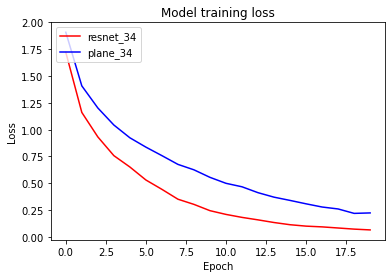

In [16]:
plt.plot(histort_resnet_34_cifar10.history['loss'], 'r')
plt.plot(histort_plane_34_cifar10.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plane_34'], loc='upper left')
plt.show()

### validation accuracy

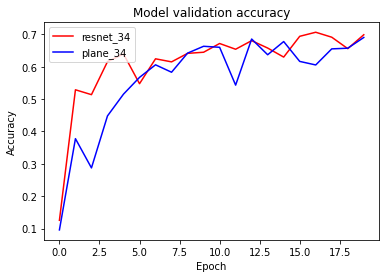

In [17]:
plt.plot(histort_resnet_34_cifar10.history['val_accuracy'], 'r')
plt.plot(histort_plane_34_cifar10.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plane_34'], loc='upper left')
plt.show()

### 결과

resnet 이 loss 가 더 낮고, validation accuracy도 초반에 더 높다가 후반에 비슷하게 수렴한다.

### 50 으로 cifar-10 훈련

In [19]:
resnet_50_cifar10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9),
    metrics=['accuracy'],
)

histort_resnet_50_cifar10 = resnet_50_cifar10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [reduce_lr]
)

Epoch 1/20
195/195 [==============================] - 66s 341ms/step - loss: 2.2149 - accuracy: 0.2651 - val_loss: 2.4298 - val_accuracy: 0.1635
Epoch 2/20
195/195 [==============================] - 21s 109ms/step - loss: 1.4453 - accuracy: 0.4928 - val_loss: 2.0209 - val_accuracy: 0.3097
Epoch 3/20
195/195 [==============================] - 22s 112ms/step - loss: 1.2413 - accuracy: 0.5747 - val_loss: 1.3649 - val_accuracy: 0.5351
Epoch 4/20
195/195 [==============================] - 22s 113ms/step - loss: 1.0411 - accuracy: 0.6439 - val_loss: 2.0398 - val_accuracy: 0.5497
Epoch 5/20
195/195 [==============================] - 21s 107ms/step - loss: 0.9071 - accuracy: 0.6930 - val_loss: 1.5189 - val_accuracy: 0.5338
Epoch 6/20
195/195 [==============================] - 21s 108ms/step - loss: 0.7469 - accuracy: 0.7448 - val_loss: 1.5348 - val_accuracy: 0.5371
Epoch 7/20
195/195 [==============================] - 22s 115ms/step - loss: 0.6256 - accuracy: 0.7888 - val_loss: 1.3994 - val_ac

In [20]:
plane_50_cifar10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9),
    metrics=['accuracy'],
)

histort_plane_50_cifar10 = plane_50_cifar10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [reduce_lr]
)

Epoch 1/20
195/195 [==============================] - 17s 87ms/step - loss: 2.3029 - accuracy: 0.1452 - val_loss: 2.3303 - val_accuracy: 0.0967
Epoch 2/20
195/195 [==============================] - 16s 84ms/step - loss: 1.8019 - accuracy: 0.3254 - val_loss: 1.9918 - val_accuracy: 0.2676
Epoch 3/20
195/195 [==============================] - 16s 83ms/step - loss: 1.5638 - accuracy: 0.4261 - val_loss: 4.7332 - val_accuracy: 0.2507
Epoch 4/20
195/195 [==============================] - 16s 84ms/step - loss: 1.3929 - accuracy: 0.4928 - val_loss: 1.6735 - val_accuracy: 0.4097
Epoch 5/20
195/195 [==============================] - 16s 83ms/step - loss: 1.2804 - accuracy: 0.5416 - val_loss: 1.6284 - val_accuracy: 0.4585
Epoch 6/20
195/195 [==============================] - 17s 87ms/step - loss: 1.1517 - accuracy: 0.5904 - val_loss: 1.7945 - val_accuracy: 0.4250
Epoch 7/20
195/195 [==============================] - 17s 87ms/step - loss: 1.0605 - accuracy: 0.6277 - val_loss: 1.4034 - val_accuracy:

## cifar-10 에 대한 resnet-50, plane-50 훈련 결과 비교

### training loss

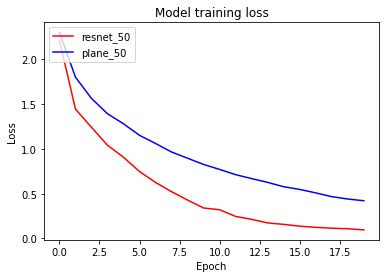

In [23]:
plt.plot(histort_resnet_50_cifar10.history['loss'], 'r')
plt.plot(histort_plane_50_cifar10.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plane_50'], loc='upper left')
plt.show()

### validation accuracy

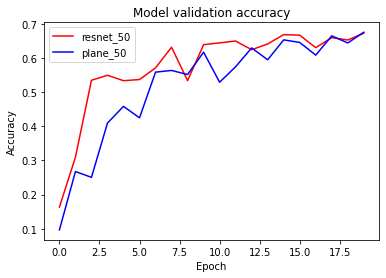

In [24]:
plt.plot(histort_resnet_50_cifar10.history['val_accuracy'], 'r')
plt.plot(histort_plane_50_cifar10.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plane_50'], loc='upper left')
plt.show()

### 결과

34 와 마찬가지로, resnet이 loss 가 더 낮고, accuracy는 비슷하다.

## input_shape (224,224,3) 으로 비교해보기 : cats vs dogs 로 비교해보기

batch_size = 256 으로는 동작이 멈춰서, 확 낮춰서 32 로 하니 되길래, 32로 진행함

In [6]:
BATCH_SIZE = 32
EPOCH = 30

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_cat_dog, ds_info_cat_dog = tfds.load(
    'cats_vs_dogs',
    split=['train'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_cat_dog = ds_cat_dog[0]

In [10]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info_cat_dog.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [11]:
TRAIN_SIZE = int(ds_info_cat_dog.splits['train'].num_examples*0.8)
TEST_SIZE = int(ds_info_cat_dog.splits['train'].num_examples*0.2)

ds_train_cat_dog = ds_cat_dog.take(TRAIN_SIZE)
ds_test_cat_dog = ds_cat_dog.skip(TRAIN_SIZE)
ds_test_cat_dog = ds_test_cat_dog.take(TEST_SIZE)

# ds_cat_dog = pd.DataFrame(ds_cat_dog[0])
# ds_cat_dog.shape

In [12]:
# msk = np.random.rand(ds_cat_dog.shape[0]) < 0.8
# ds_train_cat_dog = ds_cat_dog[msk]
# ds_test_cat_dog = ds_cat_dog[~msk]

ds_train_cat_dog = apply_normalize_on_dataset(ds_train_cat_dog, batch_size=BATCH_SIZE)
ds_test_cat_dog = apply_normalize_on_dataset(ds_test_cat_dog, batch_size=BATCH_SIZE)

In [13]:
ds_train_cat_dog

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [14]:
ds_test_cat_dog

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [15]:
cat_dog_input_shape = (224, 224, 3)
cat_dog_num_classes = 2

In [16]:
# cats_vs_dogs 을 대상으로 하는 모델
resnet_50_cat_dog = build_resnet(input_shape=cat_dog_input_shape,is_50 = True, num_classes=cat_dog_num_classes)
resnet_50_cat_dog.summary()

[0]              
__________________________________________________________________________________________________
block_2_0_bn_1 (BatchNormalizat (None, 14, 14, 256)  1024        block_2_1x1_0_1[0][0]            
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 14, 14, 256)  0           block_2_0_bn_1[0][0]             
__________________________________________________________________________________________________
block_2_conv_0 (Conv2D)         (None, 14, 14, 256)  590080      activation_22[0][0]              
__________________________________________________________________________________________________
block_2_0_bn_2 (BatchNormalizat (None, 14, 14, 256)  1024        block_2_conv_0[0][0]             
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 14, 14, 256)  0           block_2_0_bn_2[0][0]      

In [17]:
# cats_vs_dogs 을 대상으로 하는 모델
plane_50_cat_dog = build_plane(input_shape=cat_dog_input_shape,is_50 = True, num_classes=cat_dog_num_classes)
plane_50_cat_dog.summary()

__________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_49 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2_max_pool (MaxPooling2D (None, 56, 56, 64)        0         
_________________________________________________________________
block_0_1x1_0_1 (Conv2D)     (None, 56, 56, 64)        4160      
_________________________________________________________________
block_0_0_bn_1 (BatchNormali (None, 56, 56, 64)        256       
_________________________________________________________________
activation_50 (Activation)   (None, 56, 56, 64)        0         
_________________________________________________________________
block_0_conv_0 (Conv2D)  

### cifar10 데이터로는 34 로 해보았으니, 이번에는 50으로 해본다.

In [18]:
resnet_50_cat_dog.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9, clipnorm=1.),
    metrics=['accuracy'],
)

histort_resnet_50_cat_dog = resnet_50_cat_dog.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train'].num_examples*0.8/BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train'].num_examples*0.2/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 222s 382ms/step - loss: 0.7392 - accuracy: 0.5028 - val_loss: 0.7815 - val_accuracy: 0.5004
Epoch 2/30
581/581 [==============================] - 209s 359ms/step - loss: 0.7115 - accuracy: 0.5024 - val_loss: 0.7442 - val_accuracy: 0.4920
Epoch 3/30
581/581 [==============================] - 177s 304ms/step - loss: 0.7023 - accuracy: 0.5018 - val_loss: 0.7178 - val_accuracy: 0.4991
Epoch 4/30
581/581 [==============================] - 175s 301ms/step - loss: 0.6959 - accuracy: 0.5045 - val_loss: 0.7003 - val_accuracy: 0.5076
Epoch 5/30
581/581 [==============================] - 175s 301ms/step - loss: 0.6940 - accuracy: 0.5042 - val_loss: 0.6970 - val_accuracy: 0.5080
Epoch 6/30
581/581 [==============================] - 175s 301ms/step - loss: 0.6937 - accuracy: 0.5005 - val_loss: 0.7096 - val_accuracy: 0.4871
Epoch 7/30
581/581 [==============================] - 174s 300ms/step - loss: 0.6937 - accuracy: 0.5019 - val_loss: 0.6992 -

In [22]:
plane_50_cat_dog.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9, clipnorm=1.),
    metrics=['accuracy'],
)

histort_plane_50_cat_dog = plane_50_cat_dog.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train'].num_examples*0.8/BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train'].num_examples*0.2/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 146s 251ms/step - loss: 0.7002 - accuracy: 0.4975 - val_loss: 0.6975 - val_accuracy: 0.5394
Epoch 2/30
581/581 [==============================] - 146s 252ms/step - loss: 0.6948 - accuracy: 0.5045 - val_loss: 0.7000 - val_accuracy: 0.4931
Epoch 3/30
581/581 [==============================] - 145s 250ms/step - loss: 0.6937 - accuracy: 0.5048 - val_loss: 0.6940 - val_accuracy: 0.5115
Epoch 4/30
581/581 [==============================] - 145s 250ms/step - loss: 0.6935 - accuracy: 0.5029 - val_loss: 0.7007 - val_accuracy: 0.4925
Epoch 5/30
581/581 [==============================] - 145s 250ms/step - loss: 0.6935 - accuracy: 0.5021 - val_loss: 0.6946 - val_accuracy: 0.5013
Epoch 6/30
581/581 [==============================] - 146s 251ms/step - loss: 0.6934 - accuracy: 0.5043 - val_loss: 0.6936 - val_accuracy: 0.5310
Epoch 7/30
581/581 [==============================] - 146s 251ms/step - loss: 0.6934 - accuracy: 0.5099 - val_loss: 0.6933 -

### training loss

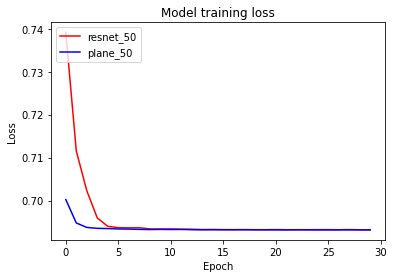

In [25]:
plt.plot(histort_resnet_50_cat_dog.history['loss'], 'r')
plt.plot(histort_plane_50_cat_dog.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plane_50'], loc='upper left')
plt.show()

### validation accuracy

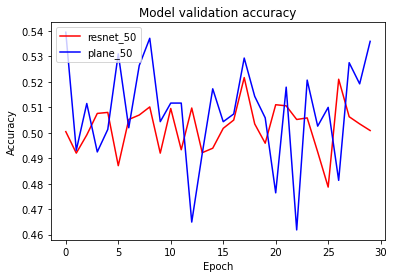

In [26]:
plt.plot(histort_resnet_50_cat_dog.history['val_accuracy'], 'r')
plt.plot(histort_plane_50_cat_dog.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plane_50'], loc='upper left')
plt.show()

### 비교 결과
loss 는 비슷하게 수렴하였고
accuracy는 둘 다 들쭉날쭉하였다.

# 결과 보고서

처음에 사용했던 cifar-10 데이터셋에 대해서는 resnet이 우월한 성능을 보여주었으나,   
두 번째로 사용한 cats_vs_dogs 데이터셋에 대해서는 plane 네트워크와 resnet의 성능이 큰 차이가 없어보였으며, 오히려 plane 네트워크가 정확도 측면에서 살짝 더 좋은 결과를 보이는 듯한 결과를 보여주기도 하였다.
모델 compile 혹은 훈련 과정에서 문제가 있었을 수도 있겠다는 생각이 든다.